# Topic Modeling with BERT

This algorithm was developed by Maarten Grootendorst in a [Medium](https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6) tutorial, in which he aimed to combine BERT and transformers embeddings. The result was BERTopic, an algorithm for generating topics using state-of-the-art embeddings.

## 1. Data

 📰 20 Newsgroups dataset: ~18000 newsgroups posts, 20 topics

In [2]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups(subset='all')['data']

## 2. Create embeddings using BERT

- First step is converting the documents to numerical data
- We will be transforming the documents in 512-dimensional vectors using using **Distilbert** as it gives a nice balance between speed and performance

In [3]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar=True)

Batches: 100%|██████████| 589/589 [05:05<00:00,  1.93it/s]


## 3. Clustering + dimensionality reduction

- We need the documents with similar topics to be clustered together, such that we can find the topics within these clusters.
- To do this, we first need to lower the dimensionality of the embeddings. 

### Dimensionality Reduction: UMAP

- We reduce the dimensionality to 5 while keeping the size of the local neighborhood at 15. You can adjust these values to optimize for the topic creation.


        💡 Dimensionality too low = loss of information Dimensionality too high = poorer clustering results



In [5]:
import umap.umap_ as umap

umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

### Clustering: HDBSAN

- HDBSCAN is a density-based algorithm that works well with UMAP as UMAP maintains a lot of local structure even in lower-dimensional space
- HDBSCAN does not force data points to clusters as it considers them outliers

In [8]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

To visualize the resulting clusters we can further reduce the dimensionality to 2 and visualize the outliers as grey points:

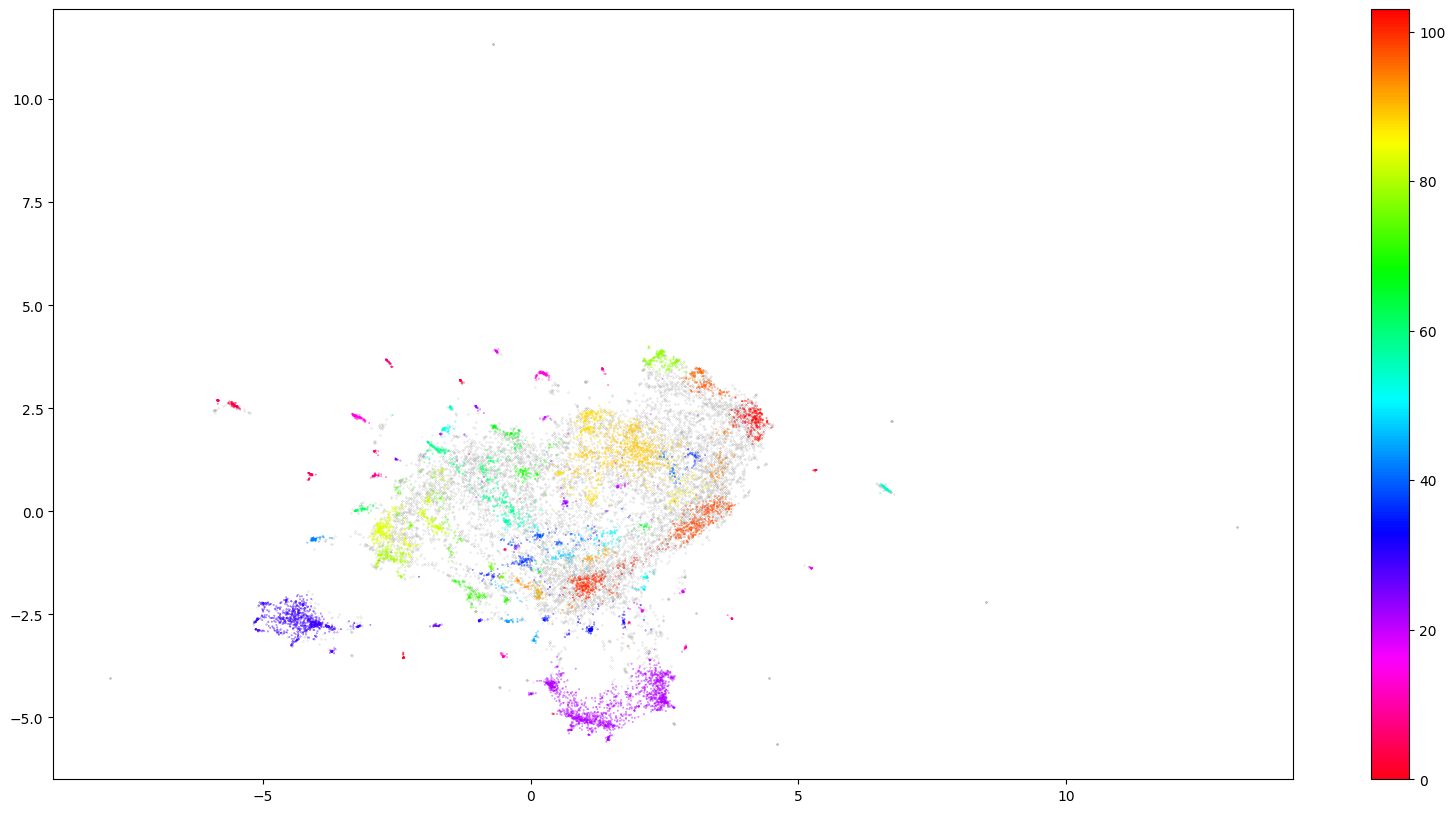

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

## Topic Creation